In [1]:
# Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import glob
from scipy import ndimage
from scipy import signal

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float

from bisect import bisect_left
import math


In [2]:
# Utility functions
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    from IPython.core.debugger import Tracer; Tracer()() 
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax


def crop_full_scan(image):
    temp = crop(image, 600, 4300, 1000, 6000)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=0.88)
    temp = crop(image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    return crop_full_scan(image)

# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

In [3]:
# Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')

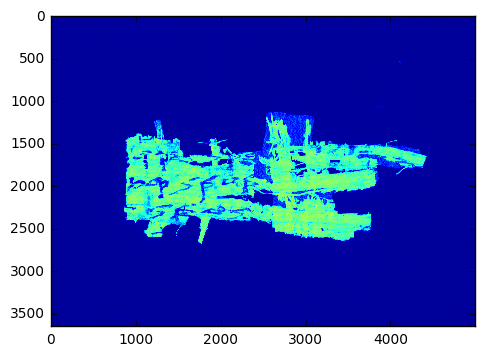

In [30]:
# TEMP!!!
image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/" + "P598-Fg009-R-C01-R01-D07012014-T124244-LR924__012.jpg")
image = crop(image, 650, 4300, 1000, 6000)
plt.imshow(image)

# flat = np.sort(np.matrix.getA1(temp))
# sum_all = np.sum(flat)
# index = np.argmin(flat.cumsum() < (sum_all * cutoff))
# temp = thresholded(temp, flat[index])


# temp = temp * 1
# temp = np.nonzero(temp)
# ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
# xmin,xmax = find_min_max_without_orphand_pixels(temp[1])

# temp = crop(image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)


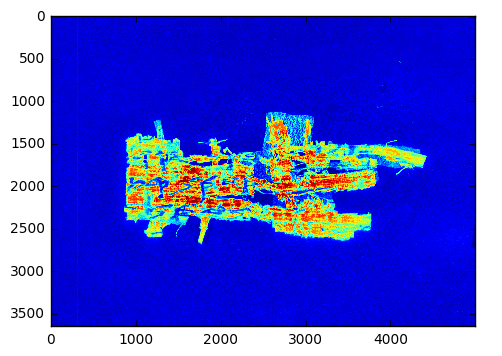

In [31]:
temp1 = exposure.equalize_adapthist(image, clip_limit=0.03)
plt.imshow(temp1)


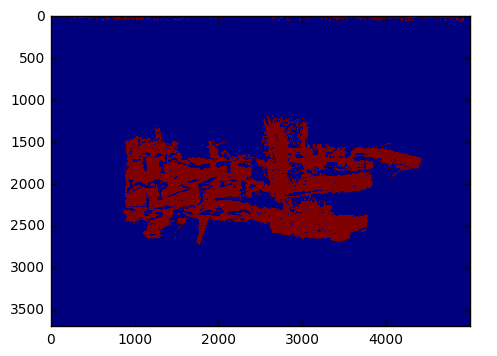

In [20]:
cutoff=0.50
flat = np.sort(np.matrix.getA1(temp1))
sum_all = np.sum(flat)
index = np.argmin(flat.cumsum() < (sum_all * cutoff))
temp = thresholded(temp1, flat[index])
plt.imshow(temp)


In [ ]:
# Read the blue wave-length image and show it
blue = read_and_crop("P598-Fg009-R-C01-R01-D07012014-T124244-LR924__012.jpg")

# Show the relevant image
plt.imshow(blue)


> <ipython-input-2-48e1da373df4>(36)calc_min_max_coordinates_dynamic()
     34 def calc_min_max_coordinates_dynamic(image, cutoff=1):
     35     from IPython.core.debugger import Tracer; Tracer()()
---> 36     temp = exposure.equalize_adapthist(image, clip_limit=0.03)
     37     flat = np.sort(np.matrix.getA1(temp))
     38     sum_all = np.sum(flat)

ipdb> image
array([[9, 9, 9, ..., 6, 6, 7],
       [9, 9, 8, ..., 6, 6, 7],
       [8, 8, 8, ..., 6, 6, 7],
       ..., 
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8],
       [8, 8, 8, ..., 8, 8, 8]], dtype=uint8)
ipdb> image.shape
(3700, 5000)


best_angle=0


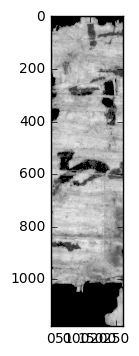

In [42]:
# Find the best rotation alignment of the image and slice the left edge (and show)
best_rotation = get_best_angle_rotation(blue, True, 280)
left_edge_rotated = slice_image_left_edge(blue, 280, best_rotation)

plt.imshow(left_edge_rotated, cmap='gray')

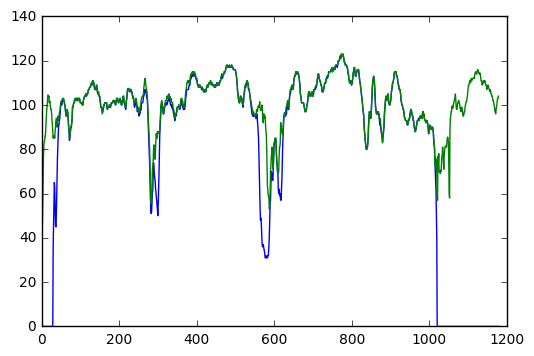

In [43]:
# Get the median for each row with (blue) and without (green) zeros
# Get the median for each row with zeros (blue)

left_med = np.median(left_edge_rotated, axis=1)

# Get the median while ignoring zeros (green)
left_edge_rotated = crop_thresholded(left_edge_rotated)
adjusted_left_median = np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]), 1, left_edge_rotated)

# Draw the median graph - reflecting a kind of a ridges fingerprint
plt.plot(left_med)
plt.plot(adjusted_left_median)

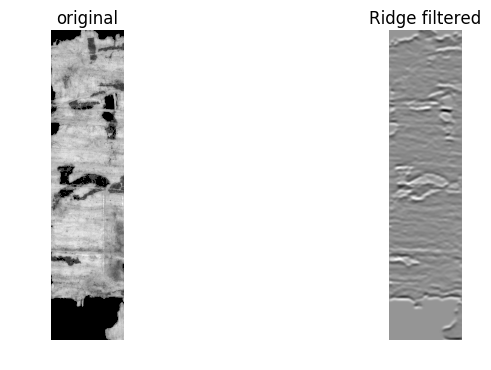

In [44]:
# Run ridge filter using the major eigenvalue of the Hessian matrix
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

# the ridge filter is the major eigenvalue of the Hessian matrix
hxx, hxy, hyy = hessian_matrix(left_edge_rotated, sigma=5)
plot_comparison(left_edge_rotated, hyy, "Ridge filtered")
i2 = hyy

# i1, i2 = hessian_matrix_eigvals(hxx, hxy, hyy)
# #i2 is the major eigenvalue...

# #Visualise the result
# # plt.imshow(i2, cmap='gray')
# plot_comparison(left_edge_rotated, i2, "Ridge filtered")

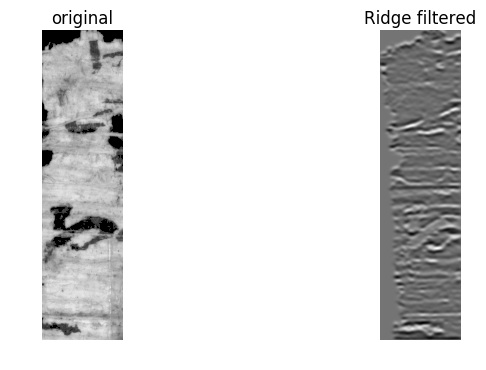

In [47]:
plot_comparison(left_edge_rotated, i1, "Ridge filtered")

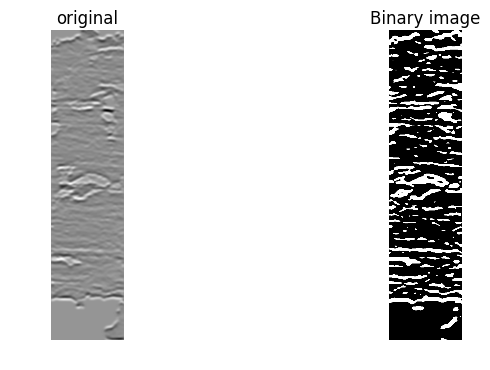

In [48]:
# Binarize the filtered image
temp = thresholded(i2, 0.00007)
temp = temp * 1
# temp = np.nonzero(temp)
plot_comparison(i2, temp, "Binary image") # Must create a binary image for the following algorithms7

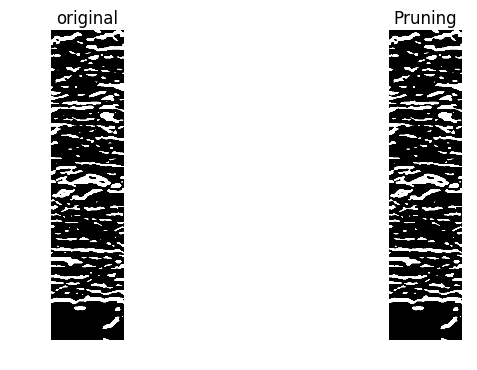

In [49]:
# Prune the binarized image (not so good)
sk = pruning(temp,3)
plot_comparison(temp, sk, "Pruning") # SO SO

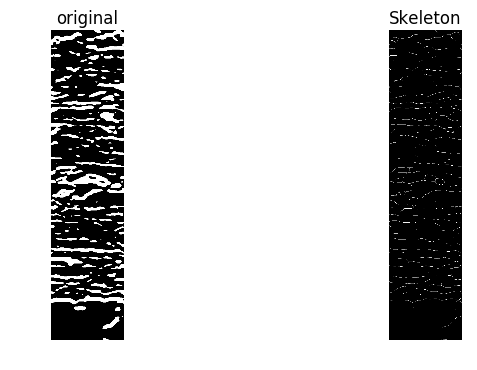

In [50]:
# Skeletonize the binarized image (not so good)
sk1 = mp.skeletonize(temp)
plot_comparison(temp, sk1, "Skeleton") # NO GOOD...

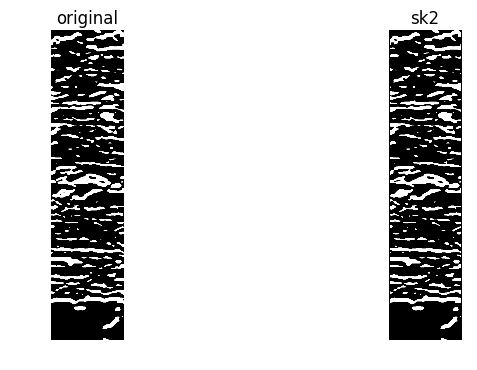

In [51]:
# Perform Binary Closing with a horizontal rectangle, in order to artificially bridge the gaps (not bad...)
sk2 = mp.binary_closing(temp, mp.rectangle(3,8))
# sk2 = mp.binary_closing(sk2)
plot_comparison(temp, sk2, 'sk2') # NOT BAD..

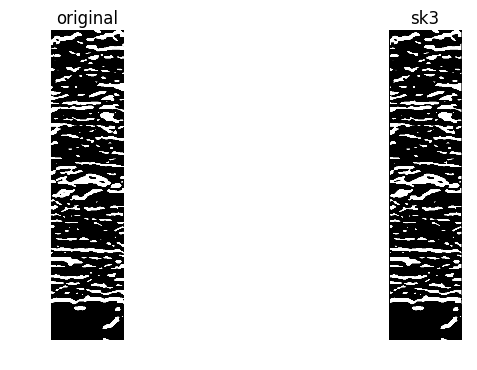

In [52]:
# Perform Regular Closing on the original filtered image and then binarize and binary closing (not bad...)
sk3 = mp.closing(i2, mp.rectangle(3,8))
sk3 = thresholded(sk3, 0.00007)
sk3 = sk3 * 1
sk3 = mp.binary_closing(sk3, mp.rectangle(1,6))
plot_comparison(temp, sk3, 'sk3')

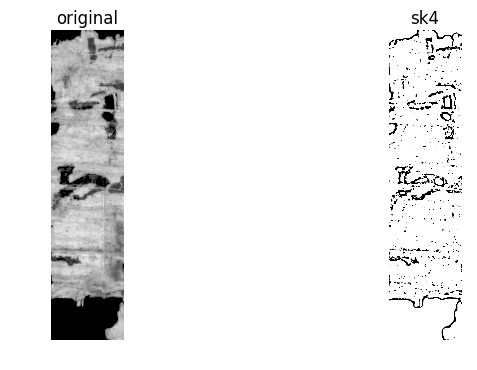

In [53]:
# Just playing.. with another filter...
import skimage.filters as ftr
block_size = 35
sk4 = ftr.threshold_adaptive(left_edge_rotated, block_size, offset=10)
plot_comparison(left_edge_rotated, sk4, 'sk4')

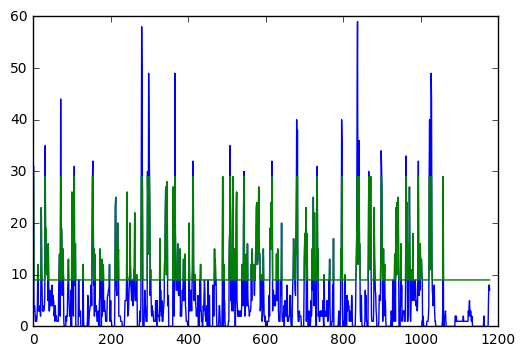

In [54]:
# Get the sum for each row (representing the ridges) and the clip the sum to avoid extremes
left_sum = np.sum(sk1, axis=1)
# Draw the sum graph - reflecting a kind of a ridges fingerprint
plt.plot(left_sum)

left_sum_clipped = np.clip(left_sum, 9, 29)
plt.plot(left_sum_clipped)


In [55]:
# Calculate PSD - Represent the power for each of the frequencies within  the data (Freq=1/pixel)


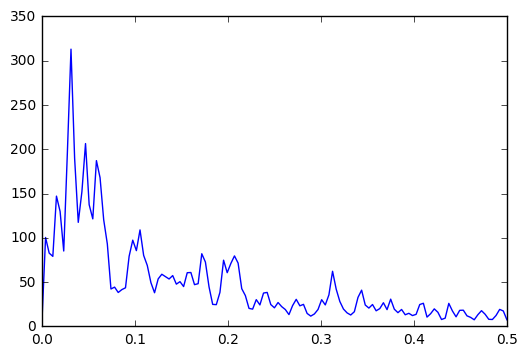

In [56]:
# Calculate PSD for the binarized clipped sum of the rows
from scipy import signal
f, pxx = signal.welch(left_sum_clipped)
plt.plot(f, pxx)


(array([ 0.        ,  0.00390625,  0.0078125 ,  0.01171875,  0.015625  ,
         0.01953125,  0.0234375 ,  0.02734375,  0.03125   ,  0.03515625,
         0.0390625 ,  0.04296875,  0.046875  ,  0.05078125,  0.0546875 ,
         0.05859375,  0.0625    ,  0.06640625,  0.0703125 ,  0.07421875,
         0.078125  ,  0.08203125,  0.0859375 ,  0.08984375,  0.09375   ,
         0.09765625,  0.1015625 ,  0.10546875,  0.109375  ,  0.11328125,
         0.1171875 ,  0.12109375,  0.125     ,  0.12890625,  0.1328125 ,
         0.13671875,  0.140625  ,  0.14453125,  0.1484375 ,  0.15234375,
         0.15625   ,  0.16015625,  0.1640625 ,  0.16796875,  0.171875  ,
         0.17578125,  0.1796875 ,  0.18359375,  0.1875    ,  0.19140625,
         0.1953125 ,  0.19921875,  0.203125  ,  0.20703125,  0.2109375 ,
         0.21484375,  0.21875   ,  0.22265625,  0.2265625 ,  0.23046875,
         0.234375  ,  0.23828125,  0.2421875 ,  0.24609375,  0.25      ,
         0.25390625,  0.2578125 ,  0.26171875,  0.2

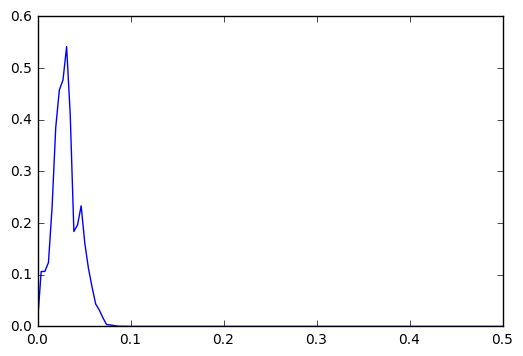

In [57]:
# Run the PSD on the ridge-filtered origin - get better results than binary
left_mean_filtered = np.sum(i2, axis=1)
f, pxx = signal.welch(left_mean_filtered[:])
plt.plot(f, pxx)

# np.set_printoptions(suppress=True)
f, pxx
# f[bisect_left(f, 0.01):]
# from bisect import bisect_left
# aa = bisect_left(f, 0.01)
# aa

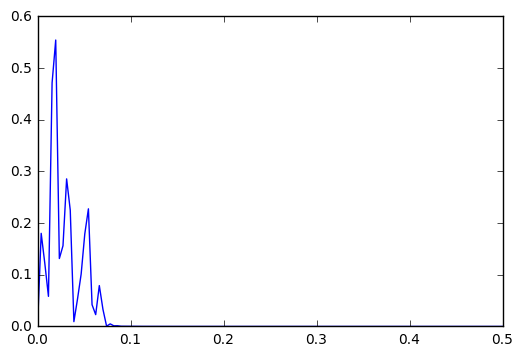

In [58]:
# Run PSD on the ridge-filtered origin ONLY in a specified 256px range => even better!
from scipy import signal
f, pxx = signal.welch(left_mean_filtered[400:656])
plt.plot(f, pxx)

# TODO: take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD

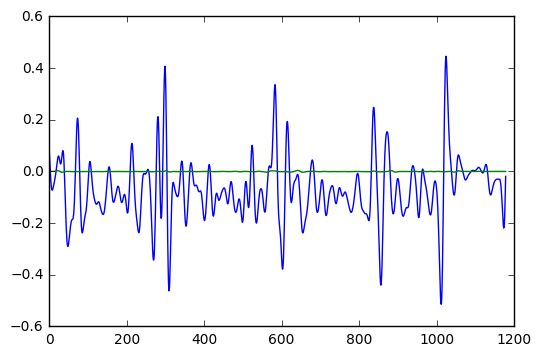

In [60]:
# Backup
plt.plot(left_mean_filtered[:])
plt.plot(i2[:,100])

In [36]:
# TEMP
def ttttest():
    global ttttt
    ttttt = 5
ttttest()
print(ttttt)

5
